**Import libraries**

In [1]:
#@title
import os
import sys

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader, ConcatDataset
from torch.backends import cudnn
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
import random

**Set arguments**

In [2]:
TRAIN_IMAGES_PATH = 'X_train.npy'
TRAIN_LABELS_PATH = 'real_classes_train.npy'
TEST_IMAGES_PATH = 'X_test.npy'
TEST_LABELS_PATH = 'real_classes_test.npy'

MEAN = (0.6499, 0.4723, 0.5844)
STD = (1, 1, 1)

NUM_CLASSES = 7

DEFAULT = True          # decide wheter to add incrementally the classes in the default order (classes then fake classes), or a mix of the two
if DEFAULT == True:
  CLASS_TO_LABEL = {'H':0, 'AC':1, 'AD':2, 'blood':3, 'fat':4, 'glass':5, 'stroma':6}
  LABEL_TO_CLASS = {0:'H', 1:'AC', 2:'AD', 3:'blood', 4:'fat', 5:'glass', 6:'stroma'}
else:
  CLASS_TO_LABEL = {'H':0, 'stroma':1, 'fat':2, 'AC':3, 'glass':4, 'blood':5, 'AD':6}
  LABEL_TO_CLASS = {0:'H', 1:'stroma', 2:'fat', 3:'AC', 4:'glass', 5:'blood', 6:'AD'}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
MOMENTUM = 0.9         
WEIGHT_DECAY = 1e-4
LR = 1
EPOCHS = 70
MILESTONES = set([ 49, 63 ])

MEMORY = 2000           # fixed size of the buffer

LAMBDA = .4             # hyper-parameter controlling the weight of the distillation
DELTA = 0.5             # value added to lambda at each incremental step
class_criterion = BCEWithLogitsLoss()
distill_criterion = F.mse_loss

LOCAL = False           # decide whether to execute the code on the colab cloud or on a local runtime
SAVE = True             # save the last trained model to be used as a teacher for knowledge distillation
PRETRAINED = True       # load the parameters learned on cifar100
FINETUNE = False        # if set to True, fine-tuning on all classes together is performed, otherwise incremental learning

SEED = 1                # for reproducibility
DIR = 'Bioinformatics'  # working directory where all the npy files should be located before starting the experiment

print("LR=" + str(LR) + ", MEMORY=" + str(MEMORY) + ", LAMBDA=" + str(LAMBDA) + ", DELTA=" + str(DELTA))

LR=1, MEMORY=2000, LAMBDA=0.4, DELTA=0.5


In [3]:
# Ensure that this line prints out 'Tesla T4' in order to obtain our same results
if DEVICE == 'cuda':
  print(torch.cuda.get_device_name(0))

Tesla T4


**Set working directory**

In [4]:
#@title
if not LOCAL:
  from google.colab import drive
  drive.mount('/content/drive')
  if ("drive/My Drive/" + DIR) not in os.getcwd():
    os.chdir(("drive/My Drive/" + DIR))
else:
  if DIR not in os.getcwd():
    os.chdir(DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Utils**

In [5]:
#@title
def imshow(image):
    image = image.cpu().numpy()
    mean = np.array(list(MEAN))
    std = np.array(list(STD))
    image = std * image + mean
    image = np.clip(image, 0, 1)

    return image

def batch_show(images, labels, bs=BATCH_SIZE):
    fig = plt.figure(figsize=(15,4))
    
    batch = min(bs, BATCH_SIZE)
    for idx in range(batch):
        ax = fig.add_subplot(1, bs, idx+1)
        title = LABEL_TO_CLASS[labels[idx].item()]
        short_title = (title[:2]) if len(title) > 2 else title
        ax.title.set_text(short_title)
        ax.axis('off')
        img = imshow(images[idx])
        ax.imshow(img)
    
    plt.show()

def updateNet(net, n_classes):
  in_features = net.fc.in_features
  out_features = net.fc.out_features
  weight = net.fc.weight.data
  bias = net.fc.bias.data

  net.fc = torch.nn.Linear(in_features, n_classes)
  net.fc.weight.data[:out_features] = weight
  net.fc.bias.data[:out_features] = bias

  return net

def getOneHot(target, n_classes):
  one_hot = torch.zeros(target.shape[0], n_classes)
  one_hot = one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
      
  return one_hot

# dict to list
def formatExemplars(exemplars):
  new_exemplars = []
  for key in exemplars:
    for item in exemplars[key]:
      new_exemplars.append([item[0],item[1]])

  return new_exemplars

def randomExemplarSet(data,n_classes):
  print('\n ### Construct Random Exemplar Set ###')
  m = int(MEMORY/(n_classes))
  print(f'   # Exemplars per class: {m}')

  # Initialize a list of exemplars for the current class
  exemplars = dict.fromkeys([n_classes-1])
  exemplars[n_classes-1] = []
  set_seed(SEED)
  indexes = random.sample(range(len(data)),m)
  for idx in indexes:
    exemplars[n_classes-1].append(data[idx])

  # return a dict where the key is the class and the value are the samples of the class
  return exemplars

def reduceExemplarSet(exemplars,n_classes):
  print('\n ### Reduce Exemplar Set ###')
  m = int(MEMORY/n_classes)
  print(f'   # Exemplars per class: {m}')
  for key in exemplars:
    exemplars[key] = exemplars[key][:m]
      
  return exemplars

def Evaluate(data,net,n_classes):
  print(f'\n ### Evaluating ###')
  net.eval()
      
  running_corrects = 0.0
  len_tot = 0
  acc = []

  for class_i in range(n_classes):
    running_corrects_class = 0
    loader = DataLoader(data[class_i], batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
    for images, labels in loader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      len_tot += len(labels)

      with torch.no_grad():
        outputs = net(images)
        
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects_class += torch.sum(preds == labels.data).data.item()
      
    accuracy_class = running_corrects_class / float(len(data[class_i])) 
    print(f"     Test accuracy for {LABEL_TO_CLASS[class_i]}: {round(accuracy_class, 2)}")

    acc.append(accuracy_class)
    running_corrects += running_corrects_class

  # Compute Accuracy
  accuracy = running_corrects / len_tot
      
  print(f'   # Total Accuracy: {round(accuracy, 2)}')
  return accuracy, acc

def plot_avg_acc(acc):
  plt.figure(figsize=(6,4))
  plt.title('Average test accuracy')
  plt.xlabel('# of classes')
  plt.ylabel('Average accuracy')
  classes = [(i+1) for i in range(NUM_CLASSES)]

  plt.plot(classes, acc, 'ro-')
  plt.show()

def plot_class_acc(acc):
  plt.figure(figsize=(10,6))
  plt.title('Class accuracy during incremental training')
  plt.xlabel('# of classes')
  plt.ylabel('Test accuracy')
  x_tcs = [i for i in range(1, NUM_CLASSES+1)]
  plt.xticks(x_tcs)

  for cl in acc:
    start = NUM_CLASSES - len(acc[cl])
    phases = [i+1 for i in range(start, NUM_CLASSES)]  
    plt.plot(phases, acc[cl], 'o-')
  
  plt.legend([cl for cl in acc])
  plt.show()

def plot_loss(losses, batch):
  plt.figure(figsize=(6,4))
  plt.title(f'Train loss over epochs for {batch+1} classes')
  plt.xlabel('Epoch')
  plt.ylabel('Train loss')

  plt.plot(losses)
  plt.show()

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

**ResNet**

In [6]:
#@title
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes):
        self.old_model = None
        self.num_classes = num_classes
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64 * block.expansion, self.num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, features=False):
        x = x.permute(0,3,1,2)
        x = x.float()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        if features:
            x = x / x.norm()
        else:
            x = self.fc(x)

        return x

def resnet32(pretrained=False, num_classes=NUM_CLASSES):
    n = 5
    if pretrained == True:
      model = ResNet(BasicBlock, [n, n, n], num_classes=100)
      model.load_state_dict(model_zoo.load_url('https://github.com/chenyaofo/CIFAR-pretrained-models/releases/download/resnet/cifar100-resnet32-6568a0a0.pth'))
      in_features = model.fc.in_features
      model.fc = torch.nn.Linear(in_features, num_classes)
    else:
      model = ResNet(BasicBlock, [n, n, n], num_classes=num_classes)
    return model

**Dataset**

In [7]:
#@title
class Hist(torch.utils.data.Dataset):
  def __init__(self, dataset):
    self.train_indices = []
    self.val_indices = []

    self.images = dataset[:,0]
    self.targets = np.array(dataset[:,1])

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.targets[idx]

    return image, label

X_train = np.load(TRAIN_IMAGES_PATH)
y_train = np.load(TRAIN_LABELS_PATH)
X_test = np.load(TEST_IMAGES_PATH)
y_test = np.load(TEST_LABELS_PATH)

# create the train dataset
train_data = []
for i in range(len(X_train)):
  train_data.append([X_train[i], CLASS_TO_LABEL[y_train[i]]])

# create the test dataset
test_data = []
for i in range(len(X_test)):
  test_data.append([X_test[i], CLASS_TO_LABEL[y_test[i]]])

train_datasets = {}
test_datasets = {}

# initialize all the single the datasets
for c in range(NUM_CLASSES):
  train_datasets[c] = []
  test_datasets[c] = []

# populate the train datasets
for i in range(len(train_data)):
  img = train_data[i][0]
  c = train_data[i][1]
  train_datasets[c].append([img, c])

print('Per Class Train sets:')
for c in range(NUM_CLASSES):
  train_dataset = Hist(np.asarray(train_datasets[c]))
  print("Class " + str(LABEL_TO_CLASS[c] + ": " + str(len(train_datasets[c])) ))

# populate the test datasets
for i in range(len(test_data)):
  img = test_data[i][0]
  c = test_data[i][1]
  test_datasets[c].append([img, c])

print('\nPer Class Test sets:')
for c in range(NUM_CLASSES):
  test_datasets[c] = Hist(np.asarray(test_datasets[c]))
  print("Class " + str(LABEL_TO_CLASS[c] + ": " + str(len(test_datasets[c]))))

Per Class Train sets:
Class H: 3000
Class AC: 3000
Class AD: 3000
Class blood: 636
Class fat: 702
Class glass: 648
Class stroma: 1350

Per Class Test sets:
Class H: 1500
Class AC: 1500
Class AD: 1500
Class blood: 570
Class fat: 522
Class glass: 639
Class stroma: 1077


**Print out samples from each class**


Samples belonging to class H:


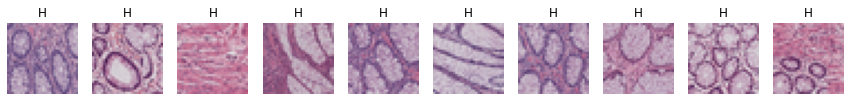


Samples belonging to class AC:


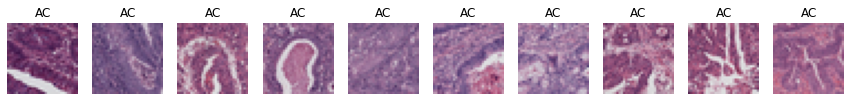


Samples belonging to class AD:


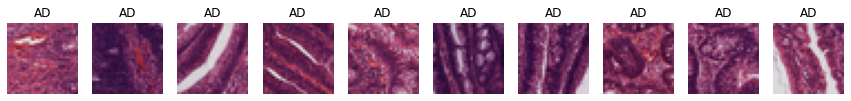


Samples belonging to class blood:


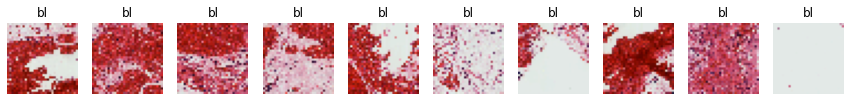


Samples belonging to class fat:


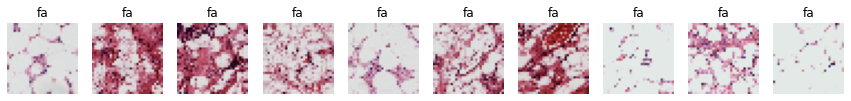


Samples belonging to class glass:


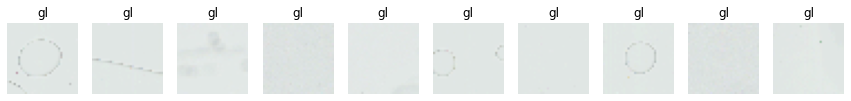


Samples belonging to class stroma:


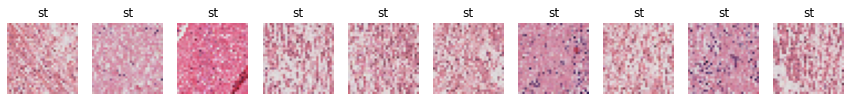

In [8]:
#@title
for label in range(NUM_CLASSES):
  train_loader = DataLoader(train_datasets[label], shuffle=False, drop_last=True, batch_size=BATCH_SIZE)
  for images, labels in train_loader:
    print(f'\nSamples belonging to class {LABEL_TO_CLASS[label]}:')
    batch_show(images, labels, 10)
    break

**Class Incremental Model**

In [9]:
#@title
class CIL():
    def __init__(self):
        self.old_net = None
        self.losses = []
 
    def __train__(self,data,exemplars,net,n_classes):
        step = int(n_classes) - 1
        lamda = LAMBDA + DELTA * (step-1)

        if len(exemplars) != 0 and FINETUNE==False:
          data = data + formatExemplars(exemplars)
          # Save network for distillation
          self.old_net = deepcopy(net)
          self.old_net.eval()
          # Update network's last layer
          net = updateNet(net,n_classes)

        # Define Dataloader
        set_seed(SEED)
        loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
        net = net.to(DEVICE)
        optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        
        for epoch in range(EPOCHS):         
          # LR step down policy
          if epoch+1 in MILESTONES:
            for g in optimizer.param_groups:
              g['lr'] = g['lr']/5
   
          # Set module in training mode
          net.train() 

          running_loss = 0.0
          for images, labels in loader:
            images = images.to(DEVICE)           
            # Get One Hot Encoding for the labels
            labels = getOneHot(labels,n_classes)
            labels = labels.to(DEVICE)

            # Zero-ing the gradients
            optimizer.zero_grad()
            # Forward pass to the network
            outputs = net(images)

            # Compute Losses
            if n_classes == 1 or FINETUNE==True:
                tot_loss = class_criterion(outputs,labels)
            else:
                with torch.no_grad():
                  old_outputs = torch.sigmoid(self.old_net(images))
                class_loss = class_criterion(outputs,labels)
                distill_loss = distill_criterion(torch.sigmoid(outputs[:,:n_classes-1]),old_outputs)
                tot_loss = class_loss + distill_loss * lamda
                
            # Update Running Loss         
            running_loss += tot_loss.item() * images.size(0)

            tot_loss.backward() 
            optimizer.step() 

          # Train loss of current epoch
          train_loss = running_loss / len(data)
          self.losses.append(train_loss)
          print('\r   # Epoch: {}/{}, LR = {},  Train loss = {}'.format(epoch+1, EPOCHS, optimizer.param_groups[0]['lr'], round(train_loss,5)),end='')
        print()

        return net

    def run(self,train_batches,net):
      exemplars = {}
      accuracy_per_batch = []

      if FINETUNE == True:
        print(f'\n#### Finetuning ####')
        n_classes = NUM_CLASSES
        train_set = []
        for i in range(n_classes):
          train_set.append(train_datasets[i])
        batch = ConcatDataset(train_set)
         # Training
        net = self.__train__(batch,exemplars,net,n_classes)

        plot_loss(self.losses, n_classes)
        self.losses = []

        # Testing
        test_batches = [test_datasets[i] for i in range(0, n_classes)]
        accuracy, _ = Evaluate(test_batches,net,n_classes)
        accuracy_per_batch.append(accuracy)

      else:
        class_accs = {}
        for idx, batch in enumerate(train_batches):
          print(f'\n#### Num. Classes: {idx+1} ####')
          n_classes = (idx+1)

          # Training
          net = self.__train__(batch,exemplars,net,n_classes)

          plot_loss(self.losses, idx)
          self.losses = []
          
          # Exemplars update
          new_exemplars = randomExemplarSet(batch,n_classes)
          exemplars.update(new_exemplars)
          
          # Testing
          test_batches = [test_datasets[i] for i in range(0, n_classes)]
          accuracy, accuracies = Evaluate(test_batches,net,n_classes)
          accuracy_per_batch.append(accuracy)

          for i in range(len(accuracies)):
            if LABEL_TO_CLASS[i] not in class_accs:
              class_accs[LABEL_TO_CLASS[i]] = []
            class_acc = accuracies[i]
            class_accs[LABEL_TO_CLASS[i]].append(class_acc)

          # Exemplars managing
          exemplars = reduceExemplarSet(exemplars,n_classes)
        plot_class_acc(class_accs)

      if SAVE == True:  
        filename = 'teacher' + ('FT' if FINETUNE==True else 'CIL') + '.pth'
        torch.save(net.state_dict(), filename)

      return accuracy_per_batch, exemplars

model = CIL()

**Training**


#### Num. Classes: 1 ####
   # Epoch: 70/70, LR = 0.04,  Train loss = 0.0


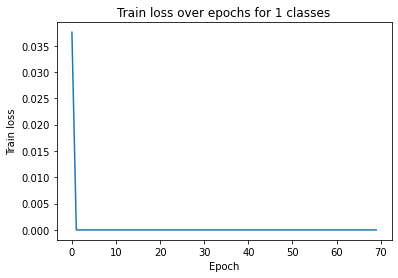


 ### Construct Random Exemplar Set ###
   # Exemplars per class: 2000

 ### Evaluating ###
     Test accuracy for H: 1.0
   # Total Accuracy: 1.0

 ### Reduce Exemplar Set ###
   # Exemplars per class: 2000

#### Num. Classes: 2 ####
   # Epoch: 70/70, LR = 0.04,  Train loss = 0.2302


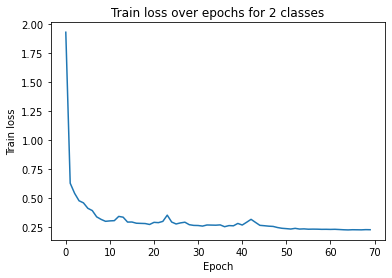


 ### Construct Random Exemplar Set ###
   # Exemplars per class: 1000

 ### Evaluating ###
     Test accuracy for H: 0.92
     Test accuracy for AC: 0.95
   # Total Accuracy: 0.94

 ### Reduce Exemplar Set ###
   # Exemplars per class: 1000

#### Num. Classes: 3 ####
   # Epoch: 70/70, LR = 0.04,  Train loss = 0.22071


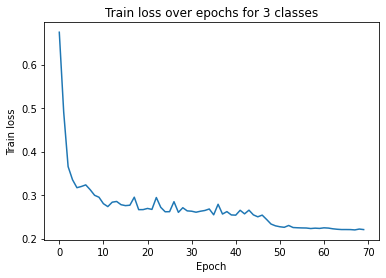


 ### Construct Random Exemplar Set ###
   # Exemplars per class: 666

 ### Evaluating ###
     Test accuracy for H: 0.9
     Test accuracy for AC: 0.95
     Test accuracy for AD: 0.89
   # Total Accuracy: 0.92

 ### Reduce Exemplar Set ###
   # Exemplars per class: 666

#### Num. Classes: 4 ####
   # Epoch: 70/70, LR = 0.04,  Train loss = 0.10437


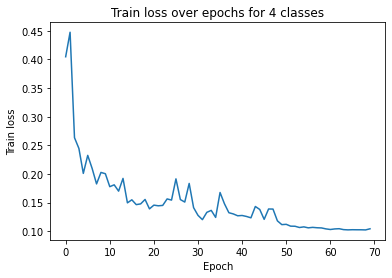


 ### Construct Random Exemplar Set ###
   # Exemplars per class: 500

 ### Evaluating ###
     Test accuracy for H: 0.94
     Test accuracy for AC: 0.96
     Test accuracy for AD: 0.92
     Test accuracy for blood: 0.99
   # Total Accuracy: 0.95

 ### Reduce Exemplar Set ###
   # Exemplars per class: 500

#### Num. Classes: 5 ####
   # Epoch: 70/70, LR = 0.04,  Train loss = 0.10162


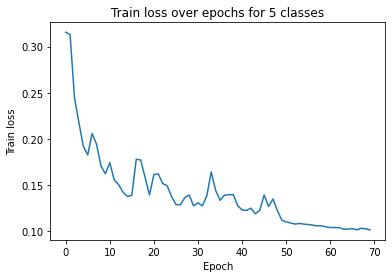


 ### Construct Random Exemplar Set ###
   # Exemplars per class: 400

 ### Evaluating ###
     Test accuracy for H: 0.95
     Test accuracy for AC: 0.96
     Test accuracy for AD: 0.85
     Test accuracy for blood: 0.95
     Test accuracy for fat: 1.0
   # Total Accuracy: 0.93

 ### Reduce Exemplar Set ###
   # Exemplars per class: 400

#### Num. Classes: 6 ####
   # Epoch: 70/70, LR = 0.04,  Train loss = 0.06479


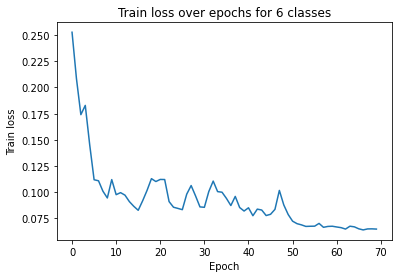


 ### Construct Random Exemplar Set ###
   # Exemplars per class: 333

 ### Evaluating ###
     Test accuracy for H: 0.94
     Test accuracy for AC: 0.96
     Test accuracy for AD: 0.94
     Test accuracy for blood: 0.96
     Test accuracy for fat: 1.0
     Test accuracy for glass: 0.99
   # Total Accuracy: 0.96

 ### Reduce Exemplar Set ###
   # Exemplars per class: 333

#### Num. Classes: 7 ####
   # Epoch: 70/70, LR = 0.04,  Train loss = 0.08363


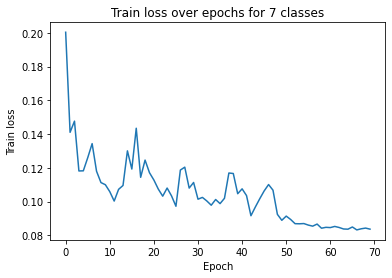


 ### Construct Random Exemplar Set ###
   # Exemplars per class: 285

 ### Evaluating ###
     Test accuracy for H: 0.93
     Test accuracy for AC: 0.94
     Test accuracy for AD: 0.92
     Test accuracy for blood: 0.95
     Test accuracy for fat: 0.99
     Test accuracy for glass: 1.0
     Test accuracy for stroma: 0.79
   # Total Accuracy: 0.92

 ### Reduce Exemplar Set ###
   # Exemplars per class: 285


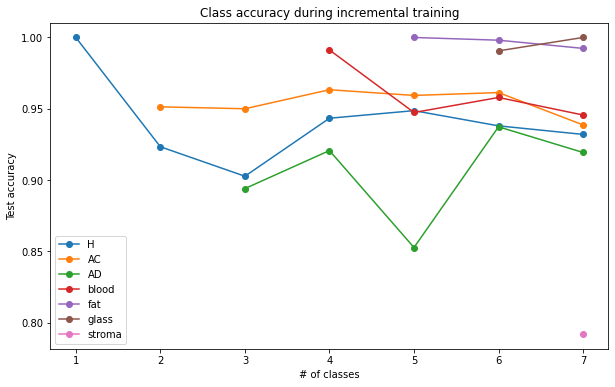

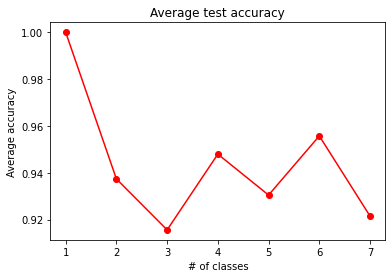

In [10]:
#@title
set_seed(SEED)
if FINETUNE == True:
  net = resnet32(pretrained=PRETRAINED, num_classes=NUM_CLASSES)
else:
  net = resnet32(pretrained=PRETRAINED, num_classes=1)
accuracies, exemplars = model.run(list(train_datasets.values()),net)
if FINETUNE == False:
  plot_avg_acc(accuracies)

**Knowledge Distillation**

In [11]:
DISTILL = True
CHECKPOINT = 'teacherFT.pth' if FINETUNE==True else 'teacherCIL.pth'

KD_EPOCHS = 50
KD_MILESTONES = [35, 45]
KD_LR = 0.1
KD_LAMBDA = 0.03

class_criterion_kd = BCEWithLogitsLoss()
distill_criterion_kd = F.mse_loss

**5-layers Network**

In [12]:
#@title
class SmallNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = x.permute(0,3,1,2)
        x = x.float()
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Network(s) initialization**

In [13]:
#@title
# teacher
tnet = resnet32(num_classes=NUM_CLASSES)
tnet = tnet.to(DEVICE)
checkpoint = torch.load(CHECKPOINT, map_location=torch.device(DEVICE))
tnet.load_state_dict(checkpoint)
tnet.eval()

# student
set_seed(SEED)
snet = SmallNet(num_classes=NUM_CLASSES)
snet = snet.to(DEVICE)

**Prepare training**

In [14]:
#@title
optimizer = torch.optim.SGD(snet.parameters(),
									lr = KD_LR, 
									momentum = MOMENTUM, 
									weight_decay = WEIGHT_DECAY)

train_set = []
for i in range(NUM_CLASSES):
  train_set.append(train_datasets[i])
train_dataset = ConcatDataset(train_set) 

set_seed(SEED)
train_loader = DataLoader(train_dataset, shuffle=True, drop_last=True, batch_size=BATCH_SIZE)

**Training**

   # Epoch: 50/50, LR = 0.004,  Train loss = 0.07933


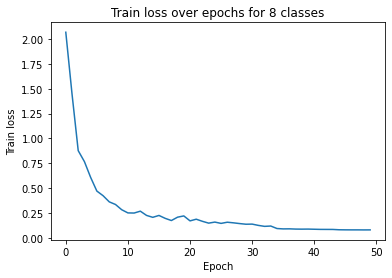

In [15]:
#@title
kd_losses = []
for epoch in range(KD_EPOCHS):
  if epoch+1 in KD_MILESTONES:
    for g in optimizer.param_groups:
      g['lr'] = g['lr']/5

  snet.train()
  running_loss = 0.0
  for i, (img, target) in enumerate(train_loader):
    img = img.to(DEVICE)
    target = getOneHot(target,NUM_CLASSES)
    target = target.to(DEVICE)
  
    optimizer.zero_grad()

    out_s = snet(img)
    cls_loss = class_criterion_kd(out_s, target)

    if DISTILL == True:
      with torch.no_grad():
        out_t = tnet(img)
      kd_loss = distill_criterion_kd(out_s, out_t) * KD_LAMBDA
      loss = cls_loss + kd_loss
    else:
      loss = cls_loss

    running_loss += loss.item() * img.size(0)
    
    loss.backward()
    optimizer.step()
  
  # Train loss of current epoch
  train_loss = running_loss / len(train_dataset)
  kd_losses.append(train_loss)
  print('\r   # Epoch: {}/{}, LR = {},  Train loss = {}'.format(epoch+1, KD_EPOCHS, optimizer.param_groups[0]['lr'], round(train_loss,5)),end='')
print()
plot_loss(kd_losses, NUM_CLASSES)

**Testing**

In [16]:
#@title
test_batches = [test_datasets[i] for i in range(0, NUM_CLASSES)]
accuracy = Evaluate(test_batches,snet,NUM_CLASSES)


 ### Evaluating ###
     Test accuracy for H: 0.9
     Test accuracy for AC: 0.71
     Test accuracy for AD: 0.88
     Test accuracy for blood: 0.95
     Test accuracy for fat: 0.95
     Test accuracy for glass: 1.0
     Test accuracy for stroma: 0.78
   # Total Accuracy: 0.86
